# Introduction:

The following is an attempt to implement the original Neural Style Transfer (NST) [paper](https://arxiv.org/pdf/1508.06576.pdf) from scratch
and in the meantime, also learn about Gradient Tape in TensorFlow.

This [link](https://www.tensorflow.org/tutorials/generative/style_transfer) helped me for this project 

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model

2021-10-12 19:12:01.000320: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
img_size = 500
vgg_pretrained = tf.keras.applications.VGG19(include_top = False, weights = "imagenet", input_shape = (img_size, img_size, 3))

for i, layer in enumerate(vgg_pretrained.layers):
   print(i, layer.name)

2021-10-12 19:12:06.147483: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-12 19:12:06.151121: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-12 19:12:06.195931: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-12 19:12:06.197063: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-10-12 19:12:06.197166: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-12 19:12:06.227816: I tensorflow/stream_executor/platform/def

80142336/80134624 [==============================] - 2s 0us/step
0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_conv4
11 block3_pool
12 block4_conv1
13 block4_conv2
14 block4_conv3
15 block4_conv4
16 block4_pool
17 block5_conv1
18 block5_conv2
19 block5_conv3
20 block5_conv4
21 block5_pool


In [3]:
vgg_pretrained.save_weights("vgg_weights.h5")

In [4]:
def gram_matrix(A):
    Gram_A = tf.linalg.matmul(A, tf.transpose(A))
    return Gram_A


# Code for this function is taken from: https://www.tensorflow.org/tutorials/generative/style_transfer
# The gram matrix defined here is different from the one in the original paper
def gram_matrix_(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    gram_matrix = tf.expand_dims(result, axis=0)
    input_shape = tf.shape(input_tensor)
    i_j = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return gram_matrix/i_j 

In [5]:
def build_activation_model():
    # This function will help to provide activations of the input image 
    # Returns a keras model
    
    vgg = tf.keras.applications.VGG19(include_top = False, weights = None, input_shape = (img_size, img_size, 3))
    vgg.load_weights("./vgg_weights.h5")
    vgg.trainable = False
    
    content_layer = "block4_conv2"
    style_layers = ["block1_conv1", "block2_conv1", "block3_conv1","block4_conv1","block5_conv1"]
    activation_content = vgg.get_layer(content_layer).output
    activations_style = [vgg.get_layer(l).output for l in style_layers]
    
    # Let's calculate the gram matrices here itself as they will be used only in the style loss function later:
    gram_style = []
#     print(activations_style[0].shape)
    for sa in activations_style:
        m, h, w, f = sa.shape # m = 1
        N_l = int(f)
        M_l = int(h * w)
        new_dim = [M_l, N_l]
        sa = tf.reshape(sa, new_dim)
        sa = tf.transpose(sa)   # N_l X M_l
        A = tf.convert_to_tensor(gram_matrix(sa))
        gram_style.append(A)
    
#     print(gram_style[0].shape)
    
    model = Model([vgg.input], [activation_content, gram_style])
    # Basic structure of a keras model: Input (vgg.input) --> Output (activations)
    
    return model

def build_activation_model_():
    # Same as the above function, but uses the other function for computing the gram matrices
    
    vgg = tf.keras.applications.VGG19(include_top = False, weights = None, input_shape = (img_size, img_size, 3))
    vgg.load_weights("./vgg_weights.h5")
    vgg.trainable = False
    
    content_layer = "block4_conv2"
    style_layers = ["block1_conv1", "block2_conv1", "block3_conv1","block4_conv1","block5_conv1"]
    activation_content = vgg.get_layer(content_layer).output
    activations_style = [vgg.get_layer(l).output for l in style_layers]
    gram_style = []
    for sa in activations_style:
        S = gram_matrix_(sa)
        m, h, w, f = S.shape
        S = tf.reshape(S, (w, f))
#         print(S.shape)
        gram_style.append(S)
        
    model = Model([vgg.input], [activation_content, gram_style])
    return model

In [6]:
def compute_content_loss(activation_content, activation_generated):
    # activation_content & activation_generated are tensors which provide the activations of the images in some layer of VGG
    m, h, w, f = activation_generated.shape  # m = 1
    dim = [int(m), int(h * w), int(f)]
    Ft = tf.reshape(activation_generated, dim)  # Transpose of F matrix as decribed in the paper
    Pt = tf.reshape(activation_content, dim)  # Transpose of P matrix as decribed in the paper
    L_content = 0.5 * (tf.reduce_sum(np.square(Ft - Pt)))
    return L_content


def compute_content_loss_(activation_content, activation_generated):
    content_loss = tf.reduce_mean((activation_generated - activation_content)**2)
    return content_loss

In [7]:
def compute_style_loss(gram_activation_style, gram_activation_generated):
    L_style = 0
    for A, G in zip(gram_activation_style, gram_activation_generated):
#         print(A.shape)
        N_l, M_l = A.shape
        factor = ((2 * N_l * M_l) ** 2)
        E_l = (tf.reduce_sum(tf.math.square(G - A))) / factor
        L_style += (E_l * 0.2)   # Uniform weight distribution

    return L_style

def compute_style_loss_(gram_activation_style, gram_activation_generated):
    L_style = tf.add_n([tf.reduce_mean((G - A)**2) for A, G in zip(gram_activation_style, gram_activation_generated)])
    L_style *= 0.2
    
    return L_style

In [8]:
def compute_total_loss(alpha, beta, L_content, L_style):
    L = alpha * L_content + beta * L_style
    return L

In [9]:
img_size = 500
alpha = 1e-1
beta = 1e-3

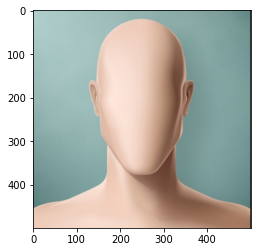

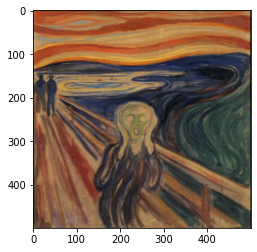

In [10]:
content_path = "../input/d/masterofsnippets/images/content_3.jpg"
style_path = "../input/d/masterofsnippets/images/style_3.jpg"

content_image = cv2.resize(cv2.imread(content_path), (img_size, img_size))
content_image = tf.image.convert_image_dtype(content_image, tf.float32)
style_image = cv2.resize(cv2.imread(style_path), (img_size, img_size))
style_image = tf.image.convert_image_dtype(style_image, tf.float32)

plt.imshow(cv2.cvtColor(np.array(content_image), cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(np.array(style_image), cv2.COLOR_BGR2RGB))
plt.show()

In [11]:
model = build_activation_model()
content_activation = model(tf.convert_to_tensor(np.array([content_image * 255])))[0]
gram_style_activations = model(tf.convert_to_tensor(np.array([style_image * 255])))[1]

style_layers = ["block1_conv1", "block2_conv1", "block3_conv1","block4_conv1","block5_conv1"]

2021-10-12 19:12:14.280477: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2021-10-12 19:12:20.205132: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-12 19:12:21.162704: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


In [12]:
model_ = build_activation_model_()
content_activation_ = model_(tf.convert_to_tensor(np.array([content_image * 255])))[0]
gram_style_activations_ = model_(tf.convert_to_tensor(np.array([style_image * 255])))[1]

style_layers = ["block1_conv1", "block2_conv1", "block3_conv1","block4_conv1","block5_conv1"]

In [13]:
print(gram_style_activations_[2].shape)
print(tf.reduce_max(gram_style_activations_[2]))

(256, 256)
tf.Tensor(392794.34, shape=(), dtype=float32)


In [14]:
# Testing the loss functions:
tmp = model(tf.convert_to_tensor(np.array([content_image])))[1]
print(compute_style_loss(gram_style_activations, tmp))

tf.Tensor(8380167500000.0, shape=(), dtype=float32)


In [15]:
opt = tf.optimizers.Adam(learning_rate=0.05, beta_1=0.99, epsilon=1e-1)

In [16]:
# @tf.function()
def train_step(generated_image, epoch):
    with tf.GradientTape() as tape:   # For auto-differentiation
        tape.watch(generated_image)
        
        # The following line doesn't work: (Don't use numpy arrays at all when using Gradient Tape)
#         generated_activations = model(tf.convert_to_tensor(np.array(generated_image)))
        # But these do:
#         generated_activations = model(generated_image*255)
        generated_activations = model_(generated_image * 255)
        
        total_loss = compute_total_loss(
            alpha,
            beta,
            compute_content_loss_(content_activation_, generated_activations[0]),
            compute_style_loss_(gram_style_activations_, generated_activations[1])
        )
    gradients = tape.gradient(total_loss, generated_image)
    opt.apply_gradients([(gradients, generated_image)])
    generated_image.assign(tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0))

    if epoch % 100 == 0:
        tf.print(f"Loss = {total_loss}")

In [17]:
epochs = 1000
generated_image = tf.image.convert_image_dtype(content_image, tf.float32)
generated_image = tf.Variable([generated_image])
# generated_image.assign(tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0))

for i in range(epochs):
    train_step(generated_image, i)

Loss = 13328617.0
Loss = 1295211.375
Loss = 307930.25
Loss = 123040.09375
Loss = 75151.390625
Loss = 57521.0546875
Loss = 49184.09765625
Loss = 44553.546875
Loss = 41691.78125
Loss = 39751.703125


In [18]:
generated_image.shape

TensorShape([1, 500, 500, 3])

In [19]:
import PIL
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

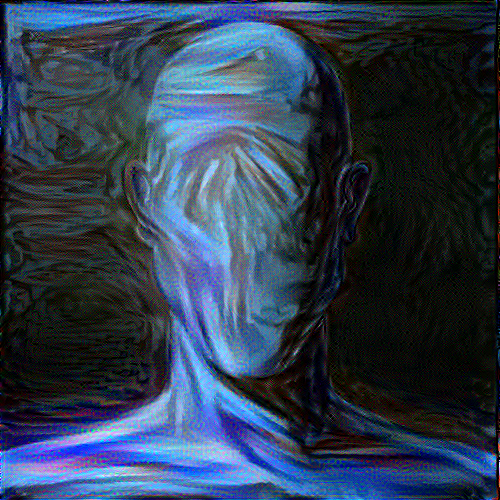

In [20]:
tensor_to_image(generated_image)

# Note that the blue tint of the image was actually not desired and it is an error. But since it looks cool on certain images,
# I have let this cell be a part of the notebook

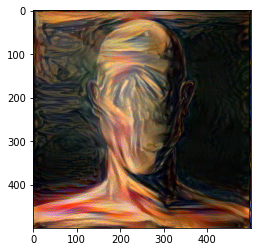

In [21]:
m, h, w, c = generated_image.shape
generated_image = tf.reshape(generated_image, (h, w, c))
plt.imshow(cv2.cvtColor(np.array(generated_image), cv2.COLOR_BGR2RGB))
plt.show()

# This is how the actual image looks like:

# **Comparing the above model with TF Hub's fast style transfer model:**

In [22]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

2021-10-12 19:13:59.616586: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-12 19:13:59.655571: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz


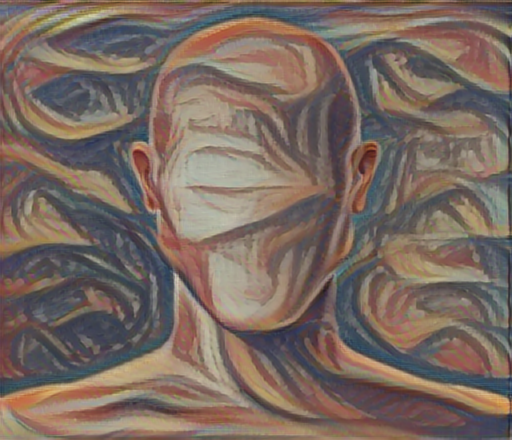

In [23]:
content_image = load_img(content_path)
style_image = load_img(style_path)

import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

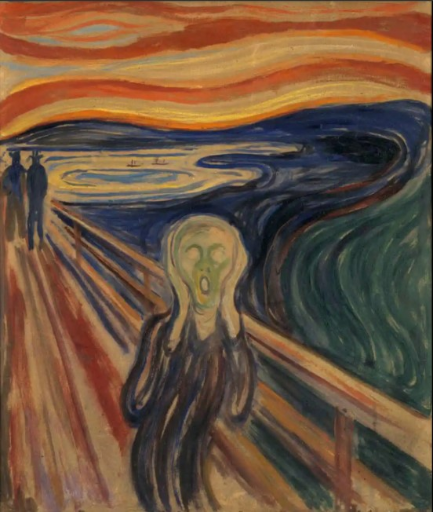

In [24]:
tensor_to_image(style_image)

# Few more examples:

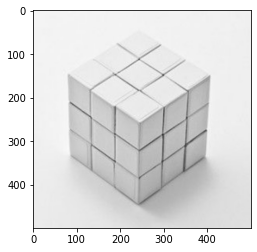

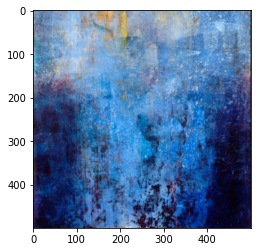

Loss = 4418168.5
Loss = 853814.5
Loss = 629623.9375
Loss = 567899.125
Loss = 539316.75
Loss = 522722.46875
Loss = 512062.1875
Loss = 505027.78125
Loss = 499575.53125
Loss = 496836.5625
Loss = 495181.6875
Loss = 494121.625
Loss = 493341.0
Loss = 492728.4375
Loss = 492246.03125


Generated image by above model:


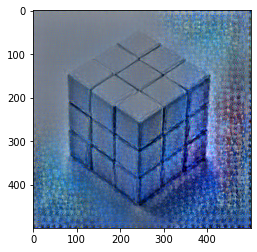


Generated image by TF' Fast NST model:


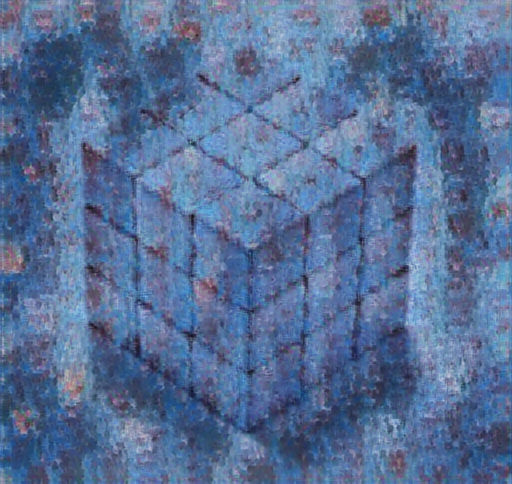

In [25]:
# Keeping the LR = 0.05 as I found it good

content_path = "../input/d/masterofsnippets/images/content_4.jpg"
style_path = "../input/d/masterofsnippets/images/style_1.jpg"

content_image = cv2.resize(cv2.imread(content_path), (img_size, img_size))
content_image = tf.image.convert_image_dtype(content_image, tf.float32)
style_image = cv2.resize(cv2.imread(style_path), (img_size, img_size))
style_image = tf.image.convert_image_dtype(style_image, tf.float32)

plt.imshow(cv2.cvtColor(np.array(content_image), cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(np.array(style_image), cv2.COLOR_BGR2RGB))
plt.show()

content_activation_ = model_(tf.convert_to_tensor(np.array([content_image * 255])))[0]
gram_style_activations_ = model_(tf.convert_to_tensor(np.array([style_image * 255])))[1]

alpha = 2
beta = 1e-4
epochs = 1500
generated_image = tf.image.convert_image_dtype(content_image, tf.float32)
generated_image = tf.Variable([generated_image])

for i in range(epochs):
    train_step(generated_image, i)
    
print("\n\nGenerated image by above model:")
m, h, w, c = generated_image.shape
generated_image = tf.reshape(generated_image, (h, w, c))
plt.imshow(cv2.cvtColor(np.array(generated_image), cv2.COLOR_BGR2RGB))
plt.show()

content_image = load_img(content_path)
style_image = load_img(style_path)

stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]

print("\nGenerated image by TF' Fast NST model:")
tensor_to_image(stylized_image)

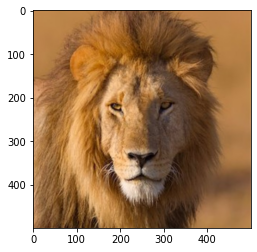

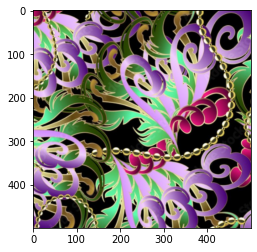

Loss = 87818616.0
Loss = 3440952.5
Loss = 1831856.375
Loss = 1472483.75
Loss = 1328558.75
Loss = 1252747.25
Loss = 1206671.375
Loss = 1176365.75
Loss = 1154980.625
Loss = 1139273.0
Loss = 1127108.75
Loss = 1117374.5
Loss = 1109234.125
Loss = 1102334.0
Loss = 1096405.5
Loss = 1091148.25
Loss = 1086563.0
Loss = 1082534.875
Loss = 1078949.375
Loss = 1075701.75
Loss = 1072752.125
Loss = 1070019.625
Loss = 1067433.0
Loss = 1064977.875
Loss = 1062693.5
Loss = 1060565.875
Loss = 1058540.625
Loss = 1056677.0
Loss = 1054929.75
Loss = 1053312.75


Generated image by above model:


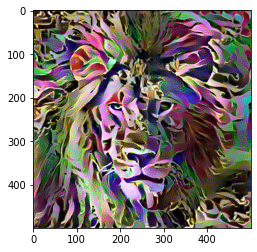


Generated image by TF' Fast NST model:


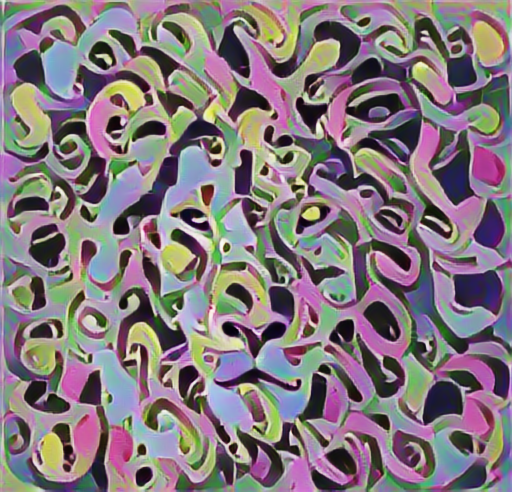

In [26]:
# Keeping the LR = 0.05 as I found it good

content_path = "../input/d/masterofsnippets/images/content_5.jpg"
style_path = "../input/d/masterofsnippets/images/style_4.jpg"

content_image = cv2.resize(cv2.imread(content_path), (img_size, img_size))
content_image = tf.image.convert_image_dtype(content_image, tf.float32)
style_image = cv2.resize(cv2.imread(style_path), (img_size, img_size))
style_image = tf.image.convert_image_dtype(style_image, tf.float32)

plt.imshow(cv2.cvtColor(np.array(content_image), cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(np.array(style_image), cv2.COLOR_BGR2RGB))
plt.show()

content_activation_ = model_(tf.convert_to_tensor(np.array([content_image * 255])))[0]
gram_style_activations_ = model_(tf.convert_to_tensor(np.array([style_image * 255])))[1]

alpha = 1
beta = 3e-4
epochs = 3000
generated_image = tf.image.convert_image_dtype(content_image, tf.float32)
generated_image = tf.Variable([generated_image])

for i in range(epochs):
    train_step(generated_image, i)
    
print("\n\nGenerated image by above model:")
m, h, w, c = generated_image.shape
generated_image = tf.reshape(generated_image, (h, w, c))
plt.imshow(cv2.cvtColor(np.array(generated_image), cv2.COLOR_BGR2RGB))
plt.show()

content_image = load_img(content_path)
style_image = load_img(style_path)

stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]

print("\nGenerated image by TF' Fast NST model:")
tensor_to_image(stylized_image)

# Remarks:
1) As could be seen from the results above, for the fast style transfer model, style seems to be more prominent  and it also tries to maintain uniformity in the style of generated image. It is also much faster than the model which was built. With that being said, I believe that the generated images of the Fast NST model are not always the better ones.

2) The logic of functions which end with an underscore were borrowed from [here](https://www.tensorflow.org/tutorials/generative/style_transfer).
 On comparing the results, I found that my loss function yields unappealing generated images and I am not sure
 why that is the case, because I have tried to implement those functions directly from the orginal research paper.
 One can try to use the loss functions written by me and compare the results.

3) One can play around with the learning rate, loss weights and number of epochs to yield better images. This
set of parameters may vary for different input style and content images.